# Assignment
## Logistic Regression and Random Forest in the credit scoring problem

## Setup

### Libraries

In [362]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from scipy.special import comb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Params

In [325]:
%matplotlib inline
rcParams["figure.figsize"] = 11, 8
sns.set()

### Methods

Let’s write the function that will replace NaN values with the median for each column.

In [326]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [327]:
def get_bootstrap_means(data, n_samples, random_seed=0):
    """Generate bootstrap samples using the bootstrap method."""
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices].mean(axis=1)
    return samples

In [328]:
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [329]:
def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries

## Introduction

### Question 1

There are 5 jurors in a courtroom. Each of them can correctly identify the guilt of the defendant with 70% probability, independent of one another. What is the probability that the jurors will jointly reach the correct verdict if the final decision is by majority vote?

- [ ] 70.00%
- [ ] 83.20%
- [+] 83.70%
- [ ] 87.50%

Great! Let’s move on to machine learning.

In [330]:
N = 5
p_0 = 0.7

result = []
for i in range(3, N + 1):
    result.append(comb(N, i) * (p_0 ** i) * (1 - p_0) ** (N - i))
    
np.round(np.sum(result) * 100, 2)

83.69

## Credit scoring problem setup

Predict whether the customer will repay their credit within 90 days. This is a binary classification problem; we will assign customers into good or bad categories based on our prediction.

In [331]:
DATA_PATH = '../../data/'

data = pd.read_csv(DATA_PATH + "credit-scoring-sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [332]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45063 entries, 0 to 45062
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      45063 non-null  int64  
 1   age                                   45063 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  45063 non-null  int64  
 3   DebtRatio                             45063 non-null  float64
 4   NumberOfTimes90DaysLate               45063 non-null  int64  
 5   NumberOfTime60-89DaysPastDueNotWorse  45063 non-null  int64  
 6   MonthlyIncome                         36420 non-null  float64
 7   NumberOfDependents                    43946 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 2.8 MB


Check the class balance:

Distribution of the target:


SeriousDlqin2yrs
0    0.777511
1    0.222489
Name: count, dtype: float64

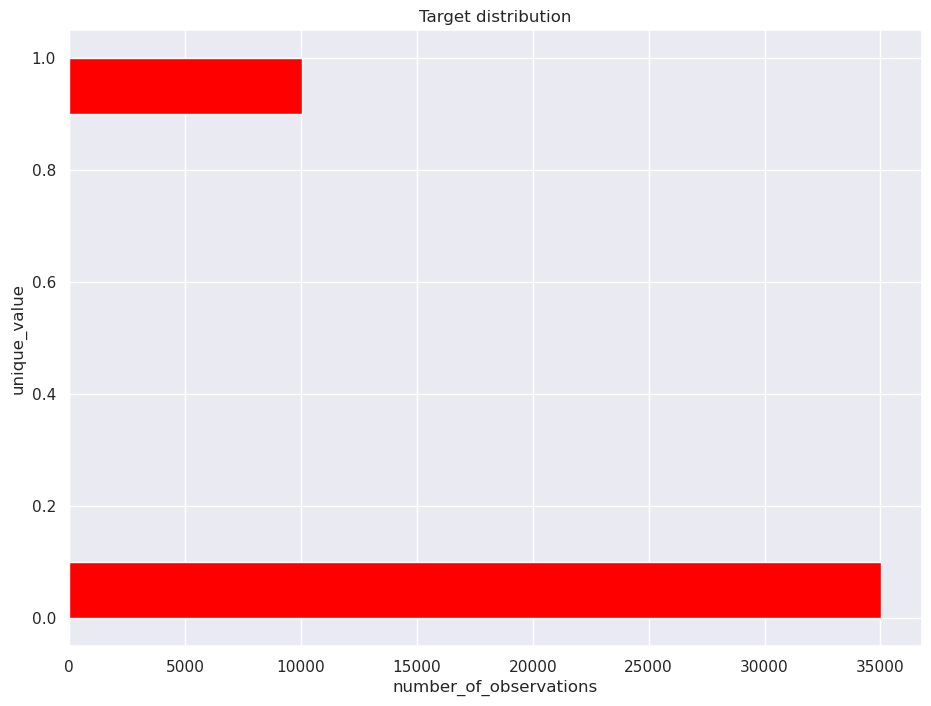

In [333]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")

ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

Separate the input variable names by excluding the target:

In [334]:
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Apply the function to replace NaN values:

In [335]:
table = fill_nan(data)
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45063 entries, 0 to 45062
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      45063 non-null  int64  
 1   age                                   45063 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  45063 non-null  int64  
 3   DebtRatio                             45063 non-null  float64
 4   NumberOfTimes90DaysLate               45063 non-null  int64  
 5   NumberOfTime60-89DaysPastDueNotWorse  45063 non-null  int64  
 6   MonthlyIncome                         45063 non-null  float64
 7   NumberOfDependents                    45063 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 2.8 MB


Separate the target variable and input features:

In [336]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

## Bootstrapping

### Question 2

Make an interval estimate of the average age for the customers who delayed repayment at the 90% confidence level. Use the example from the article as reference, if needed. Also, use np.random.seed(0) as before. What is the resulting interval estimate?

- [ ] 52.59 – 52.86
- [ ] 45.71 – 46.13
- [+] 45.68 – 46.17
- [ ] 52.56 – 52.88

In [337]:
delayed = data.loc[data['SeriousDlqin2yrs'] == 1, 'age'].values

In [338]:
sample_means = get_bootstrap_means(delayed, delayed.shape[0])

In [339]:
stat_intervals(sample_means, 0.05)

array([45.66960902, 46.18086725])

## Logistic regression

Now, we will create a LogisticRegression model and use `class_weight='balanced'` to make up for our unbalanced classes.

In [340]:
scaler = StandardScaler()

lr = LogisticRegression(
    class_weight='balanced',
    random_state=5,
)

steps = [
    #("preprocessing", scaler),
    ("classifier", lr),
]

pipe = Pipeline(steps)

Let's try to find the best regularization coefficient, which is the coefficient `C` for logistic regression. Then, we will have an optimal model that is not overfit and is a good predictor of the target variable.

In [341]:
parameters = {'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

In order to find the optimal value of `C`, let's apply stratified 5-fold validation and look at the ROC AUC against different values of the parameter `C`. Use the `StratifiedKFold` function for this:

In [342]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

One of the important metrics of model quality is the Area Under the Curve (AUC). ROC AUC varies from 0 to 1. The closer ROC AUC to 1, the better the quality of the classification model.

In [343]:
%%capture

grid = GridSearchCV(
    estimator=pipe,
    param_grid=parameters,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
)
grid.fit(X, y)

/home/diego/miniconda3/envs/ds-min/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diego/miniconda3/envs/ds-min/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

In [344]:
lf_score = grid.best_score_

In [345]:
c = grid.best_params_['classifier__C']
print(f'C: {c}')

C: 10


### Question 3

Perform a Grid Search with the scoring metric `“roc_auc”` for the parameter `C`. Which value of the parameter `C` is optimal?

- [ ] 0.0001
- [ ] 0.001
- [ ] 0.01
- [ ] 0.1
- [ ] 1
- [+] 10

### Question 4
Can we consider the best model stable? The model is stable if the standard deviation on validation is less than 0.5%. Save the ROC AUC value of the best model; it will be useful for the following tasks.

- [ ] Yes
- [+] No

In [346]:
print(f'CV score STD: {round(grid.cv_results_["std_test_score"][1] * 100, 2)} %')

CV score STD: 0.74 %


## Feature importance

### Question 5
Feature importance is defined by the absolute value of its corresponding coefficient. First, you need to normalize all of the feature values so that it will be valid to compare them. What is the most important feature for the best logistic regression model?

1. age
2. NumberOfTime30-59DaysPastDueNotWorse [+]
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

In [347]:
pd.DataFrame(
    {
        'feat': independent_columns_names,
        'coef': grid.best_estimator_['classifier'].coef_[0]
     }
).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.503801
3,NumberOfTimes90DaysLate,0.464132
4,NumberOfTime60-89DaysPastDueNotWorse,0.242505
6,NumberOfDependents,0.217222
2,DebtRatio,-0.000005
5,MonthlyIncome,-0.000013
0,age,-0.015699


### Question 6

Calculate how much `DebtRatio` affects our prediction using the softmax function. What is its value?

- [ ] 0.38
- [ ] -0.02
- [+] 0.11
- [ ] 0.24

In [348]:
coefs = grid.best_estimator_['classifier'].coef_[0]

print(
    (
        np.exp(coefs) / np.sum(np.exp(coefs))
    )[2]
)

0.11432304448304656


### Question 7
Let’s see how we can interpret the impact of our features. For this, recalculate the logistic regression with absolute values, that is without scaling. Next, modify the customer’s age by adding 20 years, keeping the other features unchanged. How many times will the chance that the customer will not repay their debt increase? You can find an example of the theoretical calculation here.

- [ ] -0.01
- [+] 0.70
- [ ] 8.32
- [ ] 0.66

In [349]:
model = LogisticRegression(
    C=c,
    class_weight='balanced',
    random_state=5,
)

model.fit(X, y)

pd.DataFrame(
    {
        'feat': independent_columns_names,
        'coef': model.coef_[0]
     }
)


/home/diego/miniconda3/envs/ds-min/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,feat,coef
0,age,-0.015699
1,NumberOfTime30-59DaysPastDueNotWorse,0.503801
2,DebtRatio,-0.000005
3,NumberOfTimes90DaysLate,0.464132
4,NumberOfTime60-89DaysPastDueNotWorse,0.242505
5,MonthlyIncome,-0.000013
6,NumberOfDependents,0.217222


In [350]:
np.exp(model.coef_[0][0] * 20)

0.7305311972789071

## Random Forest

In [351]:
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1, 
    random_state=42,
    class_weight="balanced"
)

We will search for the best parameters among the following values:

In [352]:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

In [353]:
%%capture

grid = GridSearchCV(
    estimator=rf,
    param_grid=parameters,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
)
grid.fit(X, y)

### Question 8

How much higher is the ROC AUC of the best random forest model than that of the best logistic regression on validation? Select the closest answer.

- [+] 0.04
- [ ] 0.03
- [ ] 0.02
- [ ] 0.01

In [ ]:
(grid.best_score_ / lf_score - 1)

### Question 9

What feature has the weakest impact in the Random Forest model?

- [ ] age
- [ ] NumberOfTime30-59DaysPastDueNotWorse
- [ ] DebtRatio
- [ ] NumberOfTimes90DaysLate
- [ ] NumberOfTime60-89DaysPastDueNotWorse
- [ ] MonthlyIncome
- [+] NumberOfDependents

In [361]:
pd.DataFrame(
    {
        'feat': independent_columns_names,
        'importance': grid.best_estimator_.feature_importances_
     }
).sort_values(by='importance', ascending=False)



,feat,importance
1,NumberOfTime30-59DaysPastDueNotWorse,0.300290
3,NumberOfTimes90DaysLate,0.278749
4,NumberOfTime60-89DaysPastDueNotWorse,0.156534
0,age,0.115860
2,DebtRatio,0.076082
5,MonthlyIncome,0.057994
6,NumberOfDependents,0.014491


### Question 10

What is the most significant advantage of using Logistic Regression versus Random Forest for this problem?

- [ ] Spent less time for model fitting;
- [ ] Fewer variables to iterate;
- [ ] Feature interpretability;
- [+] Linear properties of the algorithm.

## Bagging

### Question 11

Fit a bagging classifier with `random_state=42`. For the base classifiers, use 100 logistic regressors and use `RandomizedSearchCV` instead of `GridSearchCV`. It will take a lot of time to iterate over all 54 variants, so set the maximum number of iterations for RandomizedSearchCV to 20. Don’t forget to set the parameters cv and random_state=1. What is the best ROC AUC you achieve?

- [+] 80.75%
- [ ] 80.12%
- [ ] 79.62%
- [ ] 76.50%

In [375]:
parameters = {
    'max_features': [2, 3, 4],
    'max_samples': [0.5, 0.7, 0.9],
    'estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]
}

In [378]:
lr = LogisticRegression(
    class_weight='balanced',
    C=c,   
)

bg = BaggingClassifier(
    estimator=lr,
    n_estimators=100,
    n_jobs=-1,
    random_state=42
)

r_grid_search = RandomizedSearchCV(
    bg,
    parameters,
    n_jobs=-1, 
    scoring='roc_auc',
    cv=skf,
    n_iter=20,
    random_state=1,
    verbose=True
)

r_grid_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/diego/miniconda3/envs/ds-min/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diego/miniconda3/envs/ds-min/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=BaggingClassifier(estimator=LogisticRegression(C=10,
                                                                            class_weight='balanced'),
                                               n_estimators=100, n_jobs=-1,
                                               random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'estimator__C': [0.0001, 0.001, 0.01, 1,
                                                         10, 100],
                                        'max_features': [2, 3, 4],
                                        'max_samples': [0.5, 0.7, 0.9]},
                   random_state=1, scoring='roc_auc', verbose=True)

In [377]:
r_grid_search.best_score_

0.8058539684279795

### Question 12

Give an interpretation of the best parameters for bagging. Why are these values of `max_features` and `max_samples` the best?

- [ ] For bagging it’s important to use as few features as possible;
- [ ] Bagging works better on small samples;
- [+] Less correlation between single models;
- [ ] The higher the number of features, the lower the loss of information.